# Mask-RCNN for Chest X-ray Diagnostic - Starter

The goal of this notebook is to help everyone getting started with the VinBigData chest x-ray abnormalities detection competition. This is essentially an object detection problem and there is several tricky bits to it:
* Groundtruth is provided by different experts and diagnostics can vary from one expert to another.
* Images are massive
* There is a significant amount of metadata

To start in a simple way, I will resize all the images and only selected groundtruth from one expert and from the diseases with the largest bounding boxes. This data will then be fed to a MaskRCNN which, hopefully, will show some preliminary results.

In [1]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

# Data preparation

In [ ]:
training_folder = "../input/vinbigdata-chest-xray-abnormalities-detection/train/"
df = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
df = df.query("class_id<14")
df = df.query("rad_id=='R9'")

In [ ]:
df["several_issues"] = df.duplicated(subset=['image_id'])
df["box_size"] = [(row.y_max-row.y_min)*(row.x_max-row.x_min) for idx, row in df.iterrows()]

In [ ]:
df.class_name.unique()

array(['Pleural thickening', 'Nodule/Mass', 'Pulmonary fibrosis',
       'Atelectasis', 'Aortic enlargement', 'Other lesion',
       'Lung Opacity', 'ILD', 'Cardiomegaly', 'Infiltration',
       'Pleural effusion', 'Consolidation', 'Calcification',
       'Pneumothorax'], dtype=object)

In [ ]:
df.groupby("class_id")["box_size"].mean()

class_id
0     113737.328217
1     402822.769231
2      88929.848993
3     405252.227218
4     301123.621891
5     601350.573883
6     378289.608200
7     240435.082534
8      62540.092182
9     221830.790937
10    237380.216268
11     52477.879562
12    846184.200000
13    151448.671599
Name: box_size, dtype: float64

In [ ]:
df.groupby("class_id")["box_size"].std()

class_id
0      65416.233757
1     321421.285014
2     172020.886597
3     150565.684786
4     258205.197966
5     387102.522081
6     340562.614108
7     284767.617799
8     141311.531805
9     369072.777624
10    434280.323122
11     95034.054648
12    758715.693016
13    199824.385248
Name: box_size, dtype: float64

In [ ]:
df.groupby("class_id").image_id.count()

class_id
0     2541
1       78
2      298
3     1668
4      201
5      291
6      439
7     1042
8      857
9      971
10    1045
11    2466
12      75
13    1757
Name: image_id, dtype: int64

After checking the box sizes per abnormality, their standard deviation, and the number of examples, I decided to pick the 5 abnormalities below. I am carefully picking abnormalities with bounding boxes large enough as I will be significantly downsizing the images.

In [ ]:
selected_classes = [0,3,5,7,10]
category_list = ["Aortic enlargement", "Cardiomegaly", "ILD", "Lung Opacity", "Pleural effusion"]
filtered_df = df.query("class_id in @selected_classes")

In [ ]:
selected_classes_dict = {"0":0,"3":1,"5":2,"7":3,"10":4}
filtered_df["reclass_id"] = [selected_classes_dict[str(row.class_id)] for idx, row in filtered_df.iterrows()]

In [ ]:
filtered_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size,reclass_id
18,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0,0
36,be1bb194dfb986bf7554b491852b8901,Lung Opacity,7,R9,2233.0,1536.0,2518.0,1827.0,False,82935.0,3
51,abb91bdaa9d02f50bde1eaa88e13afab,Lung Opacity,7,R9,531.0,938.0,850.0,1164.0,False,72094.0,3
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,False,117729.0,0
69,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0,False,315980.0,2
...,...,...,...,...,...,...,...,...,...,...,...
67870,da95c308ecf6b869be4930aa124c0d7e,Aortic enlargement,0,R9,1614.0,698.0,1954.0,1181.0,True,164220.0,0
67885,f4da0959856bcdd4b91e0c6949b109e3,Aortic enlargement,0,R9,1567.0,827.0,1830.0,1124.0,False,78111.0,0
67889,d59d5dcc1601a29509f91dab5f8550bc,Lung Opacity,7,R9,1678.0,1097.0,1824.0,1434.0,True,49202.0,3
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,True,145222.0,4


The 2 functions below allows to go from bounding boxes to the right format for a MaskRCNN.

In [ ]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255

    return img_mask.astype(np.float32)


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

The following function is taken from raddar's [notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way) and helps to load the images in the cleanest way possible.

In [ ]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)

    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [ ]:
resized_folder = "../working/resized_train/"
os.mkdir(resized_folder)

In [ ]:
filtered_df.groupby("class_id").image_id.count()

class_id
0     2541
3     1668
5      291
7     1042
10    1045
Name: image_id, dtype: int64

As I am not going to use the full dataset in this notebook due to the processing time allowed on Kaggle Notebooks, I am sampling an even number of images per class (depending on the number of images available) to ensure I don't end up with a highly imbalanced training set.

In [ ]:
balanced_filtered_df = pd.DataFrame()
samples_per_class = 500
for class_name in filtered_df.class_name.unique():
    balanced_filtered_df = balanced_filtered_df.append(filtered_df.query("class_name==@class_name")[:samples_per_class],
                                                       ignore_index=True)

In [ ]:
balanced_filtered_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size,reclass_id
0,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0,0
1,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,False,117729.0,0
2,aa3535cb70d8142fdbdac165de546a8c,Aortic enlargement,0,R9,1293.0,748.0,1631.0,1061.0,False,105794.0,0
3,5bf3368744630f459a499ccdccc9cdf1,Aortic enlargement,0,R9,1426.0,916.0,1833.0,1452.0,False,218152.0,0
4,fa4c38b3c5e53e1e84bd0923f2d8e480,Aortic enlargement,0,R9,1397.0,849.0,1661.0,1200.0,False,92664.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2286,6e4391555899c8474c4d32f42b2ba21b,Pleural effusion,10,R9,328.0,2439.0,876.0,2617.0,True,97544.0,4
2287,2ba839f1e3d3c2d8760c11ccb7e3f01c,Pleural effusion,10,R9,94.0,2035.0,227.0,2191.0,True,20748.0,4
2288,52979eadb9adb0c1dc9a64fa0d3c4d26,Pleural effusion,10,R9,250.0,1532.0,737.0,2134.0,False,293174.0,4
2289,c85587ddf15dbf7ab134208647cb9856,Pleural effusion,10,R9,2272.0,2466.0,2433.0,2623.0,True,25277.0,4


In [ ]:
diagnostic_per_image = []

image_size=512
with tqdm(total=len(balanced_filtered_df)) as pbar:
    for idx,row in balanced_filtered_df.iterrows():
        image_id = row.image_id
        image_df = balanced_filtered_df.query("image_id==@image_id")
        class_list = []
        RLE_list = []

        for diagnostic_id, diagnostic in image_df.iterrows():
            class_list.append(diagnostic.reclass_id)

            dicom_image = read_xray(training_folder+image_id+".dicom")
            image_dimensions = dicom_image.shape

            resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
            cv2.imwrite(resized_folder+image_id+".jpg", resized_img)

            mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        pbar.update(1)

100%|██████████| 2291/2291 [1:21:34<00:00,  2.14s/it]


In [ ]:
samples_df = pd.DataFrame(diagnostic_per_image)
samples_df["Height"] = image_size
samples_df["Width"] = image_size

In [ ]:
samples_df

,image_id,CategoryId,EncodedPixels,Height,Width
0,5da264775732004f1b724b660138854a,"[0, 1]",[139889 80 140401 80 140913 80 141425 80 14193...,512,512
1,0cfae3f740f87ca3b96dec765d06fad0,[0],[130180 68 130692 68 131204 68 131716 68 13222...,512,512
2,aa3535cb70d8142fdbdac165de546a8c,[0],[138903 63 139415 63 139927 63 140439 63 14095...,512,512
3,5bf3368744630f459a499ccdccc9cdf1,[0],[131734 87 132246 87 132758 87 133270 87 13378...,512,512
4,fa4c38b3c5e53e1e84bd0923f2d8e480,[0],[159384 62 159896 62 160408 62 160920 62 16143...,512,512
...,...,...,...,...,...
2286,6e4391555899c8474c4d32f42b2ba21b,"[0, 4]",[140966 80 141478 80 141990 80 142502 80 14301...,512,512
2287,2ba839f1e3d3c2d8760c11ccb7e3f01c,[4],[12715 32 13227 32 13739 32 14251 32 14763 32 ...,512,512
2288,52979eadb9adb0c1dc9a64fa0d3c4d26,[4],[28945 107 29457 107 29969 107 30481 107 30993...,512,512
2289,c85587ddf15dbf7ab134208647cb9856,"[0, 4]",[132739 58 133251 58 133763 58 134275 58 13478...,512,512


# Train a Mask-RCNN model

I struggled a bit to make the Matterport MaskRCNN repo work with Tensorflow 2.3. In the end, I used a [PR created by tomgross](https://github.com/matterport/Mask_RCNN/pull/1896/commits/a3be0c2c8654628f10736c4dd88060440fab3968) as a base and only had a couple of fixes left to get everything running!

In [ ]:
!cp -r ../input/maskrcnn-tf2-keras ../working/maskrcnn-tf2-keras

In [ ]:
DATA_DIR = Path('../working/')
ROOT_DIR = "../../working"

NUM_CATS = len(selected_classes)
IMAGE_SIZE = 512
os.chdir('../working/maskrcnn-tf2-keras')
sys.path.append(ROOT_DIR+'/maskrcnn-tf2-keras')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
COCO_WEIGHTS_PATH = '../../input/coco-weights/mask_rcnn_coco.h5'

class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7
    # STEPS_PER_EPOCH should be the number of instances
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [ ]:
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path="../"+resized_folder+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):
        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []

        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

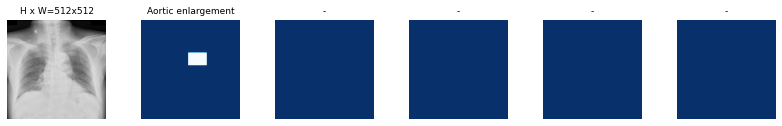

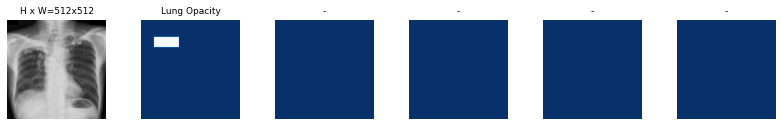

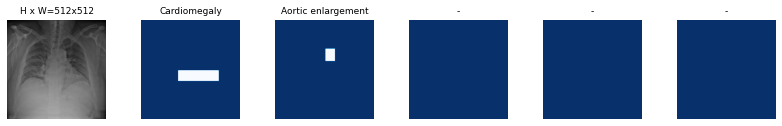

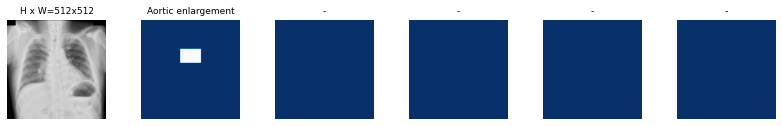

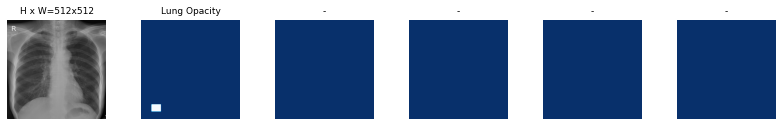

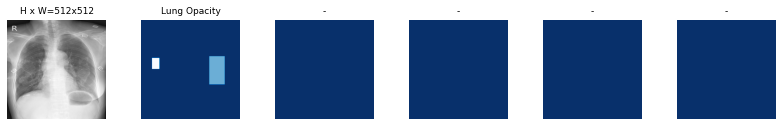

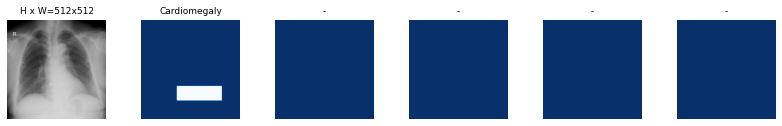

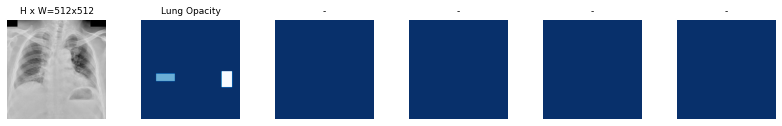

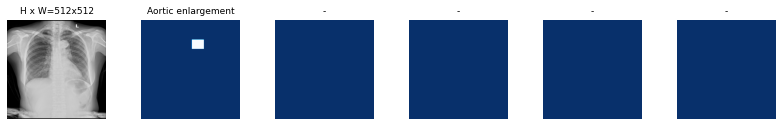

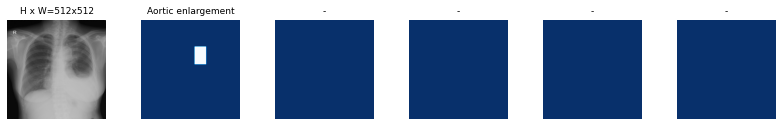

In [ ]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((1-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

for i in range(10):
    image_id = random.choice(train_dataset.image_ids)
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)

    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [ ]:
LR = 1e-4
EPOCHS = [1,18]

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Please note that there seems to be a bug which resets the loss displayed after each of the training blocks below. It did not happen in the original Matterport repo.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[0],
            layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0001

Checkpoint Path: diagnostic20210103T1813/mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/10,
            epochs=EPOCHS[1],
            layers='all')

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=1e-05

Checkpoint Path: diagnostic20210103T1813/mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

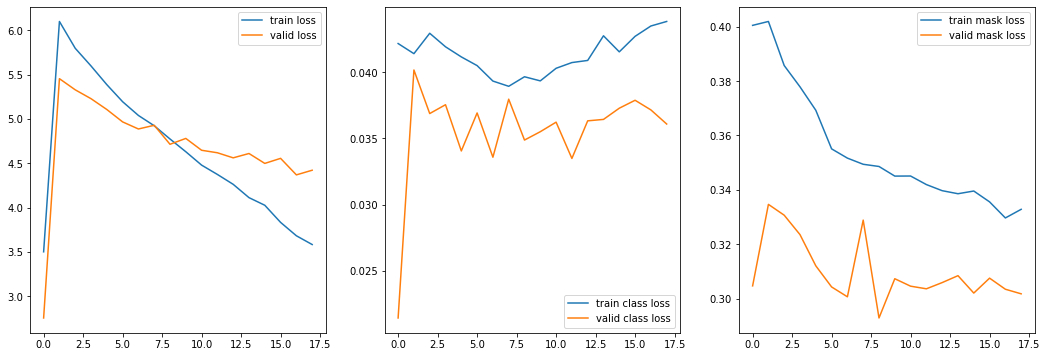

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

I am not including the loss from the training of the heads when picking the best loss because of the bug mentioned earlier.

In [ ]:
best_epoch = np.argmin(history["val_loss"][1:]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][1:][best_epoch-1])

Best epoch:  16
Valid loss:  4.3681573986912605


# Predict on test images

In [ ]:
resized_test_folder = "../../working/resized_test/"
os.mkdir(resized_test_folder)

In [ ]:
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir="")

In [ ]:
glob_list = glob.glob(f'diagnostic*/mask_rcnn_diagnostic_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

In [ ]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape

    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = resized_test_folder+"temp_image.jpg"
    cv2.imwrite(saved_filename, resized_img)
    img = cv2.imread(saved_filename)

    result = model.detect([img])
    r = result[0]

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'),
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']

    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'],
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

First, we run a test on several images and will display the results.


*** No instances to display *** 



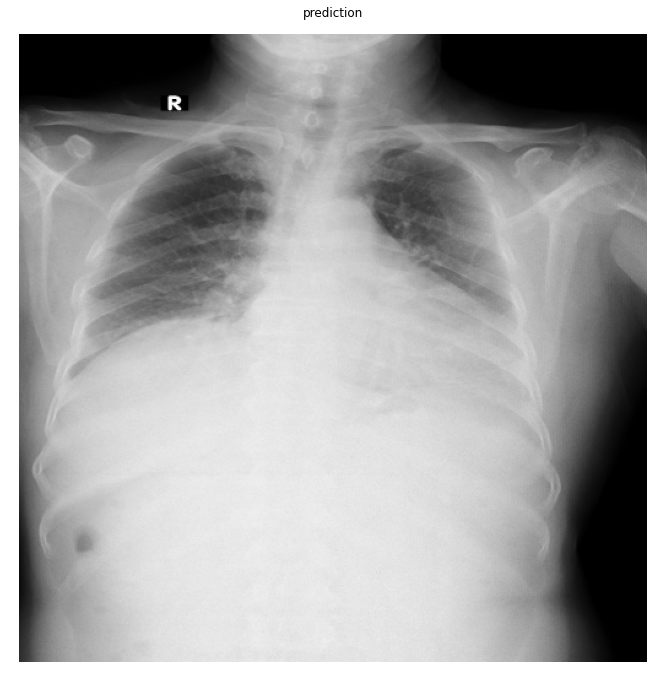

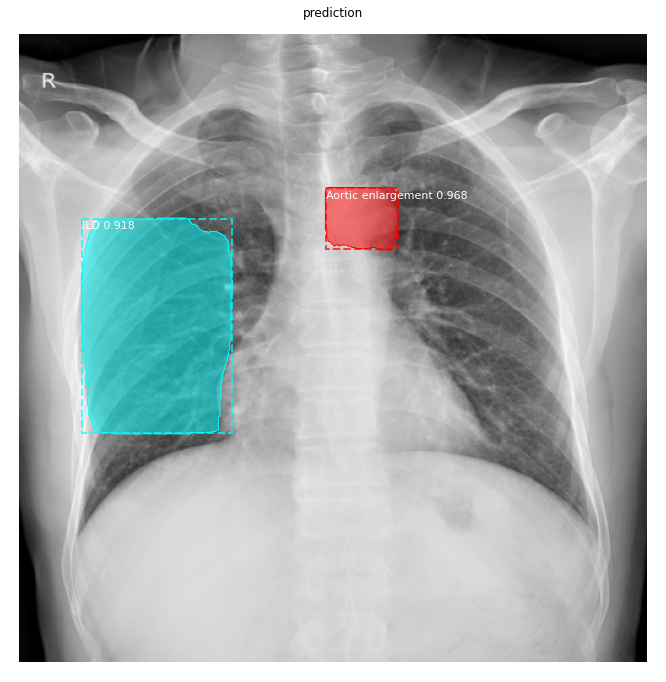

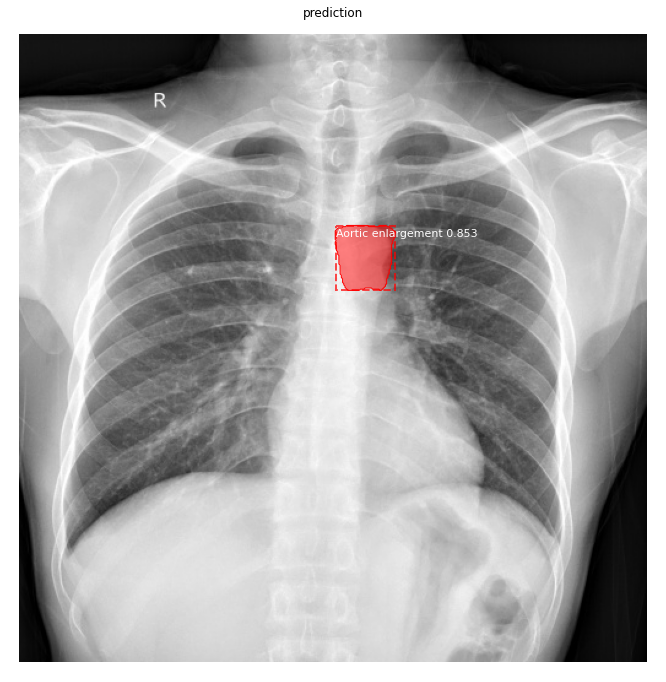

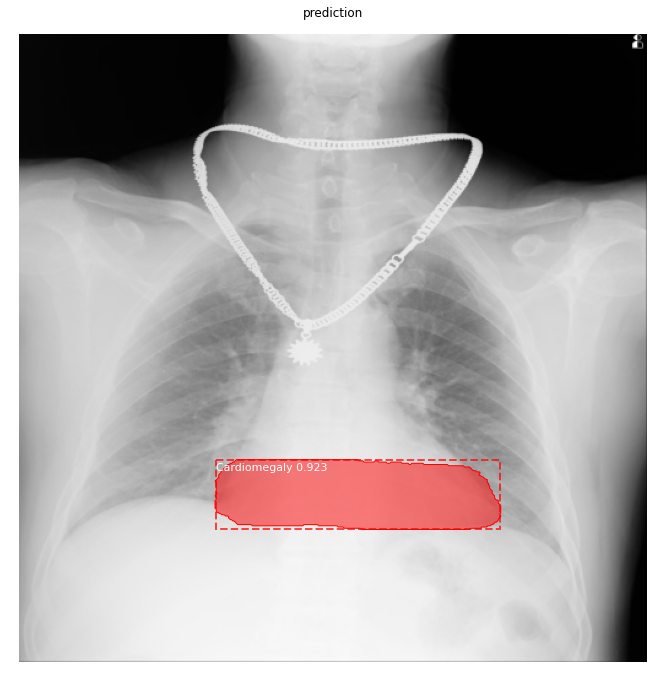

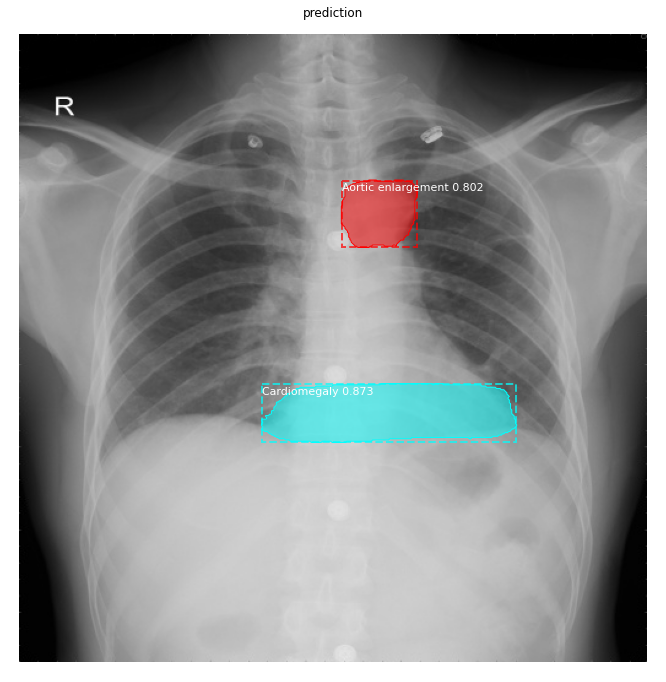

In [ ]:
test_folder = "../../input/vinbigdata-chest-xray-abnormalities-detection/test/"
test_file_list = os.listdir(test_folder)[:5]

for test_file in test_file_list:
    dicom_image = read_xray(test_folder+test_file)
    find_anomalies(dicom_image, display=True)

# Prediction and generating the submission file

Below, we run the prediction on the entire test set and format the results into a dataframe that will then be saved for submission. As it appeared that the model mistakenly gave several bounding boxes for Cardiomegaly, I am adding a function to keep only the best bounding box.

In [ ]:
def keep_best_cardiomegaly_box(bbox_list, class_list, confidence_list):
    '''
    go through the boxes and keep only one box for
    cardiomegaly with the highest confidence score
    '''
    best_cardiomegaly_score = -1
    best_cardiomegaly_bbox = []
    clean_bbox_list, clean_class_list, clean_confidence_list = [],[],[]

    for bbox, class_id, confidence in zip(bbox_list, class_list, confidence_list):
        #While the class number if 3 in the dataset, it is 2 in the maskrcnn training process
        # as I have excluded some classes
        if class_id==2:
            if confidence>best_cardiomegaly_score:
                best_cardiomegaly_score = confidence
                best_cardiomegaly_bbox = bbox
        else:
            clean_bbox_list.append(bbox)
            clean_class_list.append(class_id)
            clean_confidence_list.append(confidence)

    if best_cardiomegaly_score>0:
        clean_bbox_list.append(best_cardiomegaly_bbox)
        clean_class_list.append(2)
        clean_confidence_list.append(best_cardiomegaly_score)

    return clean_bbox_list, clean_class_list, clean_confidence_list

In [ ]:
results = []
test_file_list = os.listdir(test_folder)
with tqdm(total=len(test_file_list)) as pbar:
    for image_filename in test_file_list:
        dicom_image = read_xray(test_folder+image_filename)
        image_dimensions = dicom_image.shape
        bbox_list, class_list, confidence_list = find_anomalies(dicom_image, display=False)
        prediction_string = ""

        if len(bbox_list)>0:

            bbox_list, class_list, confidence_list = keep_best_cardiomegaly_box(bbox_list, class_list, confidence_list)

            for bbox, class_id, confidence in zip(bbox_list, class_list, confidence_list):
                class_id = next(key for key, value in selected_classes_dict.items() if value == int(class_id)-1)
                confidence_score = str(round(confidence,3))

                #HACK: I had to rescale the bounding box here. For some reason,
                #It did not do it in the prediction function.
                y_scale = image_dimensions[0]/image_size
                x_scale = image_dimensions[1]/image_size
                rescaled_bbox = (bbox * [y_scale, x_scale, y_scale, x_scale]).astype(int)

                #organise the bbox into xmin, ymin, xmax, ymax
                ymin = image_dimensions[0]-rescaled_bbox[2]
                ymax = image_dimensions[0]-rescaled_bbox[0]
                xmin = rescaled_bbox[1]
                xmax = rescaled_bbox[3]

                prediction_string += "{} {} {} {} {} {} ".format(class_id, confidence_score, xmin, ymin, xmax, ymax)
            results.append({"image_id":image_filename.replace(".dicom",""), "PredictionString":prediction_string.strip()})
        else:
            results.append({"image_id":image_filename.replace(".dicom",""), "PredictionString":"14 1.0 0 0 1 1"})
        pbar.update(1)

100%|██████████| 3000/3000 [1:11:49<00:00,  1.44s/it]


In [ ]:
submission_df = pd.DataFrame(results)

In [ ]:
submission_df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,14 1.0 0 0 1 1
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.968 1239 2038 1531 2340 5 0.918 252 1131 8...
2,74b23792db329cff5843e36efb8aa65a,0 0.853 1404 1853 1666 2170
3,94568a546be103177cb582d3e91cd2d8,3 0.923 623 518 1526 784
4,6da36354fc904b63bc03eb3884e0c35c,0 0.802 1056 1574 1301 1824 3 0.873 795 836 16...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.935 1403 2062 1646 2372
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.819 1740 1764 2046 2082 3 0.812 1428 1068 ...
2997,33218cf183c1224a74ccfb514e827e15,5 0.801 1574 937 2071 2332
2998,04b700c4815f088728db9f093c739707,0 0.867 1300 1742 1576 1987 3 0.862 980 683 19...


In [ ]:
submission_df.to_csv('../submission.csv', index=False)

### Thanks for reading this notebook! If you found this notebook helpful, please give it an upvote. It is always greatly appreciated

In [ ]:
#clear all the images from the working directory
!rm -rf ../../working/resized_train/
!rm -rf ../../working/resized_test/